In [1]:
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [140]:
def safe_vector(x):
    if x is None:
        a = np.zeros(768)
        a[0] = 1
        return a
    else:
        return x['vector']


df = pd.read_json("../data/processed/works.jsonl", lines=True)
print(df.shape)
df = df[~df.id.duplicated()]
print(df.shape)

# Get the classification from OpenAI
df_class = pd.read_json(
    "../data/processed/coarse_classification.jsonl", lines=True
)
df_class = df_class[~df_class.id.duplicated(keep='last')]
df = df.merge(df_class, on="id", how="left")
print(df.shape)

df_ss = pd.read_json("../data/processed/semantic_scholar.jsonl", lines=True, engine='pyarrow')
df_ss['embedding'] = df_ss['result'].map(lambda x: safe_vector(x['embedding']))

df_ss["ss_cited_by_count"] = df_ss["result"].map(
    lambda x: x["citationCount"]
)
df_ss = df_ss[["id", "ss_cited_by_count", "embedding"]]
df_ss[~df_ss.id.duplicated()]

# Do a left join on the paper ID
df = df.merge(df_ss, on="id", how="left")
print(df.shape)

cites = (df["oa_neuro_citations"].values >= 2) | (
    df["ss_neuro_citations"].values >= 2
)
keywords = df["keywords_found"].values >= 1

# Get the coarse classification from the keyword-based detection.
df_class = pd.read_json("../data/processed/categories.jsonl", lines=True)
df_class = df_class[~df_class.id.duplicated(keep='last')]
df = df.merge(df_class, on="id", how="left")

df_embedding = pd.read_json("../data/processed/semantic_embeddings.jsonl", lines=True)
df_embedding = df_embedding[~df_embedding.id.duplicated(keep='last')]
df = df.merge(df_embedding, on="id", how="left")
print(df.shape)

(37524, 31)
(36948, 31)
(36948, 36)
(36948, 38)
(36948, 40)


In [153]:
import hdbscan

df_ = df[df.openai_category == 'A']
X = df_.embedding_y.values.tolist()

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean')
labels = clusterer.fit_predict(X)

In [156]:
df_[labels == 1]

,id,doi,title,display_name,publication_year,publication_date,ids,primary_location,type,open_access,...,abstract,keywords_found,oa_neuro_citations,oa_cited_journals,ss_neuro_citations,ss_cited_journals,ss_cited_by_count,embedding_x,openai_category,embedding_y
127,https://openalex.org/W2133257461,None,Sparse deep belief net model for visual area V2,Sparse deep belief net model for visual area V2,2007,2007-12-03,{'openalex': 'https://openalex.org/W2133257461...,"{'is_oa': False, 'landing_page_url': 'http://a...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Motivated in part by the hierarchical organiza...,5.0,8.0,"The Journal of Physiology, Vision Research, Vi...",5.0,"Current Biology, Vision Research, Vision Resea...",1066.0,"[-4.500461101531982, -1.25899076461792, 3.3881...",A,"[-0.018410556, 0.009638387, 0.0026502125, -0.0..."
146,https://openalex.org/W2139047169,None,Saliency Based on Information Maximization,Saliency Based on Information Maximization,2005,2005-12-05,{'openalex': 'https://openalex.org/W2139047169...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,A model of bottom-up overt attention is propos...,2.0,0.0,,0.0,,1224.0,"[-0.07067842781543732, -4.51436710357666, 4.31...",A,"[-0.02593223, 0.021043148, 0.02751281000000000..."
438,https://openalex.org/W2169561119,None,Predicting human gaze using low-level saliency...,Predicting human gaze using low-level saliency...,2007,2007-12-03,{'openalex': 'https://openalex.org/W2169561119...,"{'is_oa': False, 'landing_page_url': 'http://a...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,"Under natural viewing conditions, human observ...",0.0,12.0,"Current Opinion in Neurobiology, Neuropsycholo...",12.0,"Vision Research, Neuron, Vision Research, Visi...",524.0,"[-2.303687810897827, -4.0537495613098145, 2.32...",A,"[-0.014638068, 0.015916208, 0.016736908, -0.01..."
722,https://openalex.org/W2964115671,None,Direct Feedback Alignment Provides Learning in...,Direct Feedback Alignment Provides Learning in...,2016,2016-01-01,{'openalex': 'https://openalex.org/W2964115671...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Artificial neural networks are most commonly t...,1.0,1.0,Nature Reviews Neuroscience,1.0,Nature Reviews Neuroscience,306.0,"[-2.3833487033843994, -2.79158353805542, -0.85...",A,"[-0.03812112, 0.011723384, 0.0048892144, -0.00..."
773,https://openalex.org/W2114168642,None,One-shot learning by inverting a compositional...,One-shot learning by inverting a compositional...,2013,2013-12-05,{'openalex': 'https://openalex.org/W2114168642...,"{'is_oa': False, 'landing_page_url': 'http://d...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,People can learn a new class from just one exa...,0.0,9.0,"Psychological Review, Psychological Review, Co...",4.0,"Neuropsychologia, NeuroImage, American Journal...",218.0,"[-2.631121873855591, -3.3521621227264404, 1.19...",A,"[-0.0048758476, 0.014923152, 0.008936222, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33120,https://openalex.org/W4312527777,https://doi.org/10.1109/cvpr52688.2022.00042,RecDis-SNN: Rectifying Membrane Potential Dist...,RecDis-SNN: Rectifying Membrane Potential Dist...,2022,2022-06-01,{'openalex': 'https://openalex.org/W4312527777...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,The brain-inspired and event-driven Spiking Ne...,1.0,0.0,,0.0,,16.0,"[0.4223653972148895, -0.5852596163749695, -1.6...",A,"[-0.03386349, 0.0019470123, 0.0259509400000000..."
34850,https://openalex.org/W3202619090,None,Incorporating Learnable Membrane Time Constant...,Incorporating Learnable Membrane Time Constant...,2020,2020-07-11,{'openalex': 'https://openalex.o

In [131]:

df_[labels==1].sort_values('ss_cited_by_count', ascending=False)
#(labels == 0).mean()
#labels == -1

,id,doi,title,display_name,publication_year,publication_date,ids,primary_location,type,open_access,...,abstract,keywords_found,oa_neuro_citations,oa_cited_journals,ss_neuro_citations,ss_cited_journals,ss_cited_by_count,embedding_x,openai_category,embedding_y
32521,https://openalex.org/W3037532699,None,Image-to-image Mapping with Many Domains by Sp...,Image-to-image Mapping with Many Domains by Sp...,2020,2020-06-23,{'openalex': 'https://openalex.org/W3037532699...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Unsupervised image-to-image translation consis...,2.0,0.0,,0.0,,0.0,"[-1.672010898590088, -3.6536552906036377, 0.73...",A,"[-0.010674138000000001, -0.013286971500000001,..."
32522,https://openalex.org/W3037532699,None,Image-to-image Mapping with Many Domains by Sp...,Image-to-image Mapping with Many Domains by Sp...,2020,2020-06-23,{'openalex': 'https://openalex.org/W3037532699...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Unsupervised image-to-image translation consis...,2.0,0.0,,0.0,,0.0,"[-1.672010898590088, -3.6536552906036377, 0.73...",A,"[-0.010674138000000001, -0.013286971500000001,..."
32523,https://openalex.org/W3037532699,None,Image-to-image Mapping with Many Domains by Sp...,Image-to-image Mapping with Many Domains by Sp...,2020,2020-06-23,{'openalex': 'https://openalex.org/W3037532699...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Unsupervised image-to-image translation consis...,2.0,0.0,,0.0,,0.0,"[-1.672010898590088, -3.6536552906036377, 0.73...",A,"[-0.010674138000000001, -0.013286971500000001,..."
32524,https://openalex.org/W3037532699,None,Image-to-image Mapping with Many Domains by Sp...,Image-to-image Mapping with Many Domains by Sp...,2020,2020-06-23,{'openalex': 'https://openalex.org/W3037532699...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Unsupervised image-to-image translation consis...,2.0,0.0,,0.0,,0.0,"[-1.672010898590088, -3.6536552906036377, 0.73...",A,"[-0.010674138000000001, -0.013286971500000001,..."
32525,https://openalex.org/W3037532699,None,Image-to-image Mapping with Many Domains by Sp...,Image-to-image Mapping with Many Domains by Sp...,2020,2020-06-23,{'openalex': 'https://openalex.org/W3037532699...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Unsupervised image-to-image translation consis...,2.0,0.0,,0.0,,0.0,"[-1.672010898590088, -3.6536552906036377, 0.73...",A,"[-0.010674138000000001, -0.013286971500000001,..."
32526,https://openalex.org/W3037532699,None,Image-to-image Mapping with Many Domains by Sp...,Image-to-image Mapping with Many Domains by Sp...,2020,2020-06-23,{'openalex': 'https://openalex.org/W3037532699...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Unsupervised image-to-image translation consis...,2.0,0.0,,0.0,,0.0,"[-1.672010898590088, -3.6536552906036377, 0.73...",A,"[-0.010674138000000001, -0.013286971500000001,..."
32527,https://openalex.org/W3037532699,None,Image-to-image Mapping with Many Domains by Sp...,Image-to-image Mapping with Many Domains by Sp...,2020,2020-06-23,{'openalex': 'https://openalex.org/W3037532699...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Unsupervised image-to-image translation consis...,2.0,0.0,,0.0,,0.0,"[-1.672010898590088, -3.6536552906036377, 0.73...",A,"[-0.010674138000000001, -0.013286971500000001,..."
32528,https://openalex.org/W3037532699,None,Image-to-image Mapping with Many Domains by Sp...,Image-to-image Mapping with Many Domains by Sp...,2020,2020-06-

In [28]:
#plt.imshow(np.corrcoef(X[labels==0, :]))
df_ = df[df.openai_category == 'A']
df_[labels == 0]

,id,doi,title,display_name,publication_year,publication_date,ids,primary_location,type,open_access,...,abstract,keywords_found,oa_neuro_citations,oa_cited_journals,ss_neuro_citations,ss_cited_journals,ss_cited_by_count,embedding,openai_category,axis_aligned
2812,https://openalex.org/W2143938301,None,Modeling Saccadic Targeting in Visual Search,Modeling Saccadic Targeting in Visual Search,1995,1995-11-27,{'openalex': 'https://openalex.org/W2143938301...,"{'is_oa': False, 'landing_page_url': 'http://p...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Visual cognition depends critically on the abi...,0.0,4.0,"Cognitive Psychology, Cognitive Psychology, Be...",3.0,"Behavioral and Brain Sciences, Cognitive Psych...",61.0,"[-5.353053092956543, -2.685553789138794, 2.468...",A,62.100586
3255,https://openalex.org/W2963463006,None,Task-driven convolutional recurrent models of ...,Task-driven convolutional recurrent models of ...,2018,2018-12-01,{'openalex': 'https://openalex.org/W2963463006...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Feed-forward convolutional neural networks (CN...,3.0,0.0,,7.0,"Nature Neuroscience, Nature Neuroscience, PLoS...",121.0,"[-2.548363447189331, -2.1441657543182373, 3.11...",A,66.957815
4323,https://openalex.org/W2165217178,None,Top-Down Control of Visual Attention: A Ration...,Top-Down Control of Visual Attention: A Ration...,2005,2005-12-05,{'openalex': 'https://openalex.org/W2165217178...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Theories of visual attention commonly posit th...,0.0,6.0,"Psychonomic Bulletin & Review, Journal of Expe...",4.0,"Memory & Cognition, Journal of Experimental Ps...",34.0,"[-4.331010818481445, -4.602914333343506, 2.962...",A,63.876539
4989,https://openalex.org/W2120078010,None,VISIT: A Neural Model of Covert Visual Attention,VISIT: A Neural Model of Covert Visual Attention,1991,1991-12-02,{'openalex': 'https://openalex.org/W2120078010...,"{'is_oa': False, 'landing_page_url': 'http://p...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Visual attention is the ability to dynamically...,4.0,5.0,"Annual Review of Neuroscience, The Journal of ...",2.0,"Annual Review of Neuroscience, Journal of Expe...",32.0,"[-4.208893775939941, -1.9414870738983154, 3.36...",A,66.439898
5222,https://openalex.org/W3103272223,None,Simulating a Primary Visual Cortex at the Fron...,Simulating a Primary Visual Cortex at the Fron...,2020,2020-01-01,{'openalex': 'https://openalex.org/W3103272223...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Abstract Current state-of-the-art object recog...,5.0,0.0,,16.0,"Neuron, Nature Neuroscience, Neuron, Nature Ne...",106.0,"[-1.0430970191955566, -1.5302278995513916, 4.2...",A,66.901703
5651,https://openalex.org/W2143558878,None,Perceiving Complex Visual Scenes: An Oscillato...,Perceiving Complex Visual Scenes: An Oscillato...,1992,1992-11-30,{'openalex': 'https://openalex.org/W2143558878...,"{'is_oa': False, 'landing_page_url': 'https://...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,Which processes underly our ability to quickly...,1.0,4.0,"Journal of Experimental Psychology: General, T...",1.0,Journal of Cognitive Neuroscience,18.0,"[-1.9083625078201294, -4.182024955749512, 4.19...",A,63.833821
6004,https://openalex.org/W2138665783,None,Correlates of Attention in a Model of Dynamic ...,Correlates of Attention in a Model of Dynamic ...,1997,1997-12-01,{'openalex': 'https://openalex.org/W2138665783...,"{'is_oa': False, 'landing_page_url': 'http://h...",proceedings-article,"{'is_oa': False, 'oa_status': 'closed', 'oa_ur...",...,"Given a set of objects in the visual field, ho...",3.0,3.0,"Annual Review of Neuroscience, The Journa

1182

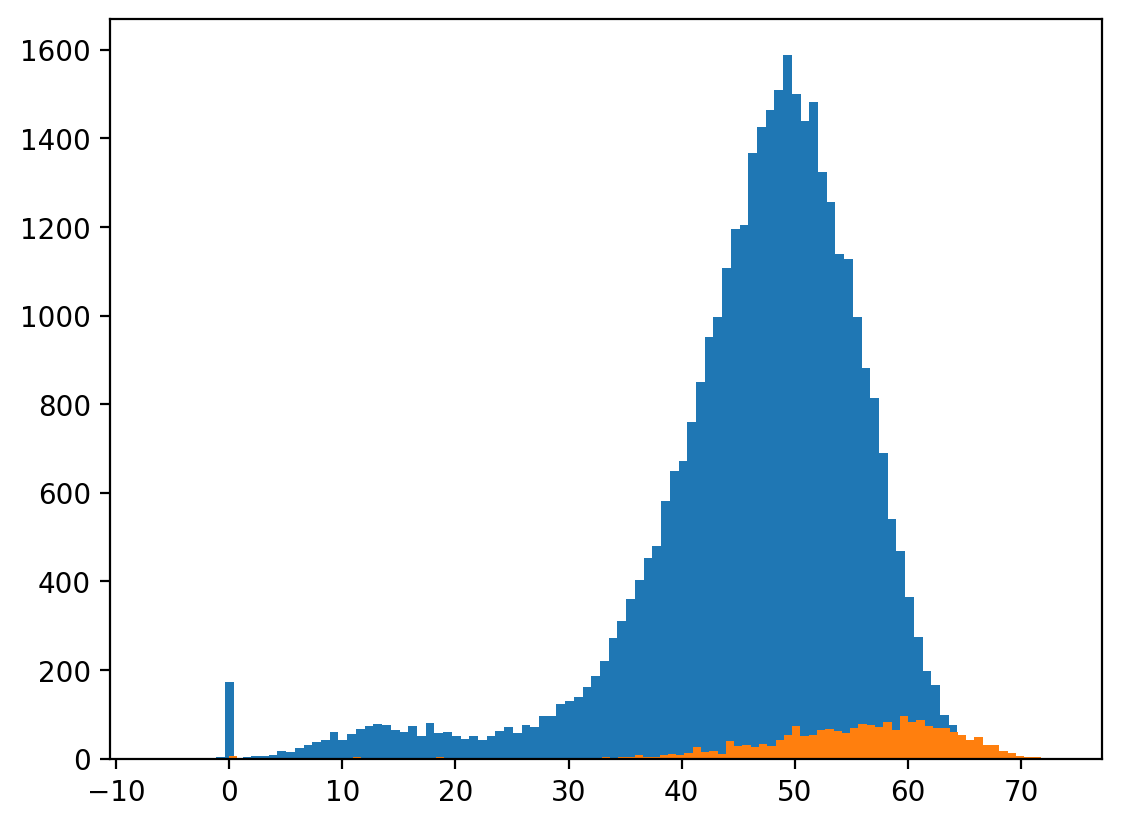

In [90]:
df["axis_aligned"] = features @ mean_axis

_ = plt.hist(df[~cites].axis_aligned, 100)
_ = plt.hist(df[cites].axis_aligned, 100)

(df.loc[~cites, 'axis_aligned'] > 60).sum()

In [102]:
df[~cites & (df.loc[:, 'axis_aligned'] > 60)].iloc[6].abstract

'In a traditional convolutional layer, the learned filters stay fixed after training. In contrast, we introduce a new framework, the Dynamic Filter Network, where filters are generated dynamically conditioned on an input. We show that this architecture is a powerful one, with increased flexibility thanks to its adaptive nature, yet without an excessive increase in the number of model parameters. A wide variety of filtering operation can be learned this way, including local spatial transformations, but also others like selective (de)blurring or adaptive feature extraction. Moreover, multiple such layers can be combined, e.g. in a recurrent architecture. We demonstrate the effectiveness of the dynamic filter network on the tasks of video and stereo prediction, and reach state-of-the-art performance on the moving MNIST dataset with a much smaller model. By visualizing the learned filters, we illustrate that the network has picked up flow information by only looking at unlabelled training 

In [42]:
features = np.vstack(df.embedding.values.tolist())

In [12]:
df_classes = pd.read_json("../data/processed/coarse_classification.jsonl", lines=True)
((df_classes.ss_neuro_citations >= 2) | (df_classes.oa_neuro_citations >= 2) | (df_classes.keywords_found >= 1)).sum()

2869

In [12]:
df = pd.read_json("../data/processed/works.jsonl", lines=True)

with open("../data/processed/features.pkl", "rb") as f:
    features = pickle.load(f)

df["neuro_related"] = np.where(features.sum(axis=1) >= 1, 1, 0)

with open("../data/processed/categories.pkl", "rb") as f:
    outputs = pickle.load(f)

category = np.zeros(df.shape[0], dtype=object)
category[df["neuro_related"].values == 1] = outputs

df["category"] = category

Text(0, 0.5, '# papers')

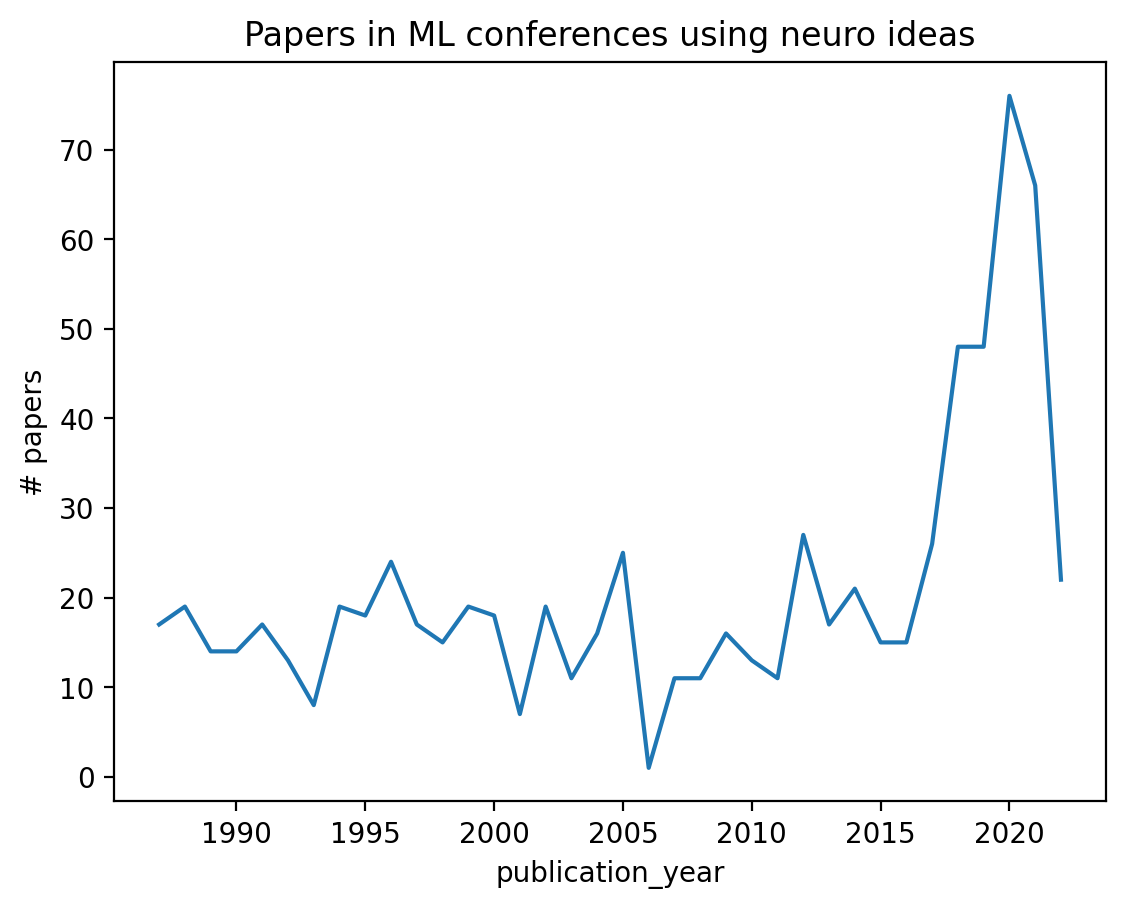

In [13]:
df[df.category.isin(['A', 'C'])].groupby('publication_year').count().title.plot()
plt.title('Papers in ML conferences using neuro ideas')
plt.ylabel('# papers')

Text(0, 0.5, '% papers')

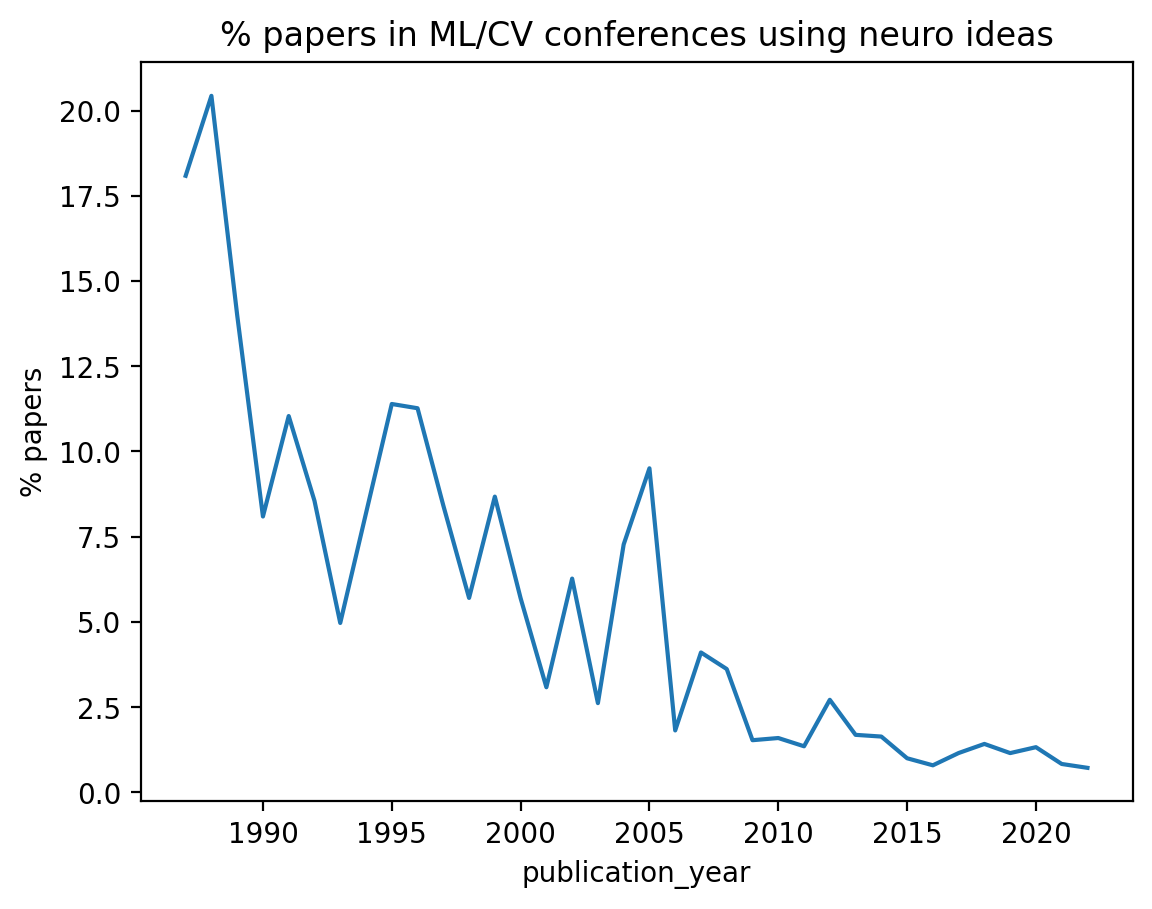

In [14]:
# Add up 2021 and 2022.
count_0 = df[df.category.isin(['A', 'C'])].groupby('publication_year').count().title
count_1 = df.groupby('publication_year').count().title
(100 * (count_0 / count_1)).plot()
plt.title('% papers in ML/CV conferences using neuro ideas')
plt.ylabel('% papers')

Text(0.5, 1.0, 'Total papers in ML/CV conferences')

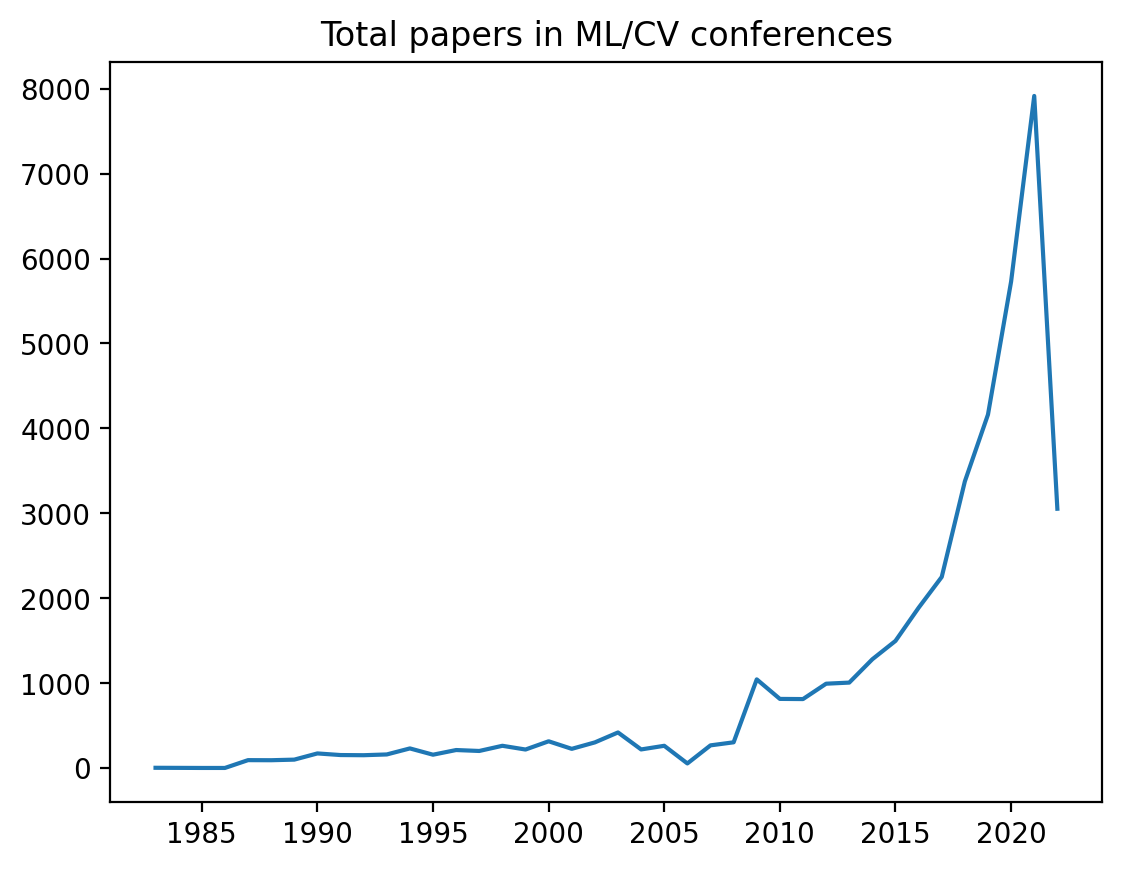

In [15]:
count_1 = df.groupby('publication_year').count().title
plt.plot(count_1)
plt.title('Total papers in ML/CV conferences')

In [18]:
df_ref = pd.read_json("../data/processed/references.jsonl", lines=True)

In [36]:
import json
from pprint import pprint
import collections

known_concepts = {
    "Neuroscience",
    "Psychology",
    "Visual cortex",
    "Stimulus (psychology)",
    "Receptive field",
    "Perception",
    "Neural coding",
    "Sensory system",
    "Cognitive psychology",
    "Macaque",
    "Excitatory postsynaptic potential",
    "Cognition",
    "Postsynaptic potential",
    "Eye movement",
    "Functional magnetic resonance imaging",
    "Visual search",
    "Electroencephalography",
    "Synaptic plasticity",
    "Cognitive science",
    "Long-term potentiation",
    "Simple cell",
    "Inhibitory postsynaptic potential",
    "Hippocampal formation",
    "Hebbian theory",
    "Binocular neurons",
    "Neocortex",
    "Striate cortex",
    "Spike-timing-dependent plasticity",
    "Orientation column",
    "Metaplasticity",
    "Brain–computer interface",
    "Auditory cortex",
    "Retina",
    "Somatosensory system",
    "Surround suppression",
    "Saccadic masking",
    "Psychophysics",
    "Saccade",
    "Primate",
    "Spike train",
    "Neuroimaging",
    "Gaze",
    "Nonsynaptic plasticity",
    "Prefrontal cortex",
    "Hippocampus",
    "Adaptation (eye)",
    "Motor imagery",
    "Neural decoding",
    "Neurophysiology",
}

known_journals = {
    'PLOS Computational Biology',
    'Trends in Neurosciences',
    'Vision Research',
    'Nature Neuroscience',
    'Journal of Neurophysiology',
    'Neuron',
    'Psychological Science',
    'Psychological Review',
    'Current Opinion in Neurobiology',
    'The Journal of Neuroscience',
    'Cognition',
    'Trends in Cognitive Sciences',
    'Journal of experimental psychology',
    'Cerebral Cortex',
    'The Journal of Physiology',
    'Cognitive Psychology',
    'PLOS Biology',
    'Behavioral and Brain Sciences',
    'Journal of Vision',
    'Nature Reviews Neuroscience',
    'Annual Review of Neuroscience',
    'Experimental Brain Research',
    'American Journal of Psychology',
    'Behavioral Ecology and Sociobiology',
    'Neurobiology of Learning and Memory',
    "European Journal of Neuroscience",
    "Neurocomputing",
    "Attention Perception & Psychophysics",
    "Current Biology",
    "Electroencephalography and Clinical Neurophysiology",
    "Progress in Brain Research",
    "Developmental Psychology",
    "NeuroImage",
    "Memory & Cognition",
    "Visual Neuroscience",
    "Journal of Computational Neuroscience",
    "Clinical Neurophysiology",
    "Proceedings of the Annual Meeting of the Cognitive Science Society",
    "Neuropsychologia",
    "Quarterly Journal of Experimental Psychology",
    "Psychonomic Bulletin & Review",
    "Journal of Cognitive Neuroscience",
    "Psychology Press eBooks",
    "Journal of Personality and Social Psychology",
    "Current Directions in Psychological Science",
    "Biological Psychology",
    "Brain and Cognition",
    "Neurobiology of Learning and Memory",
    "Spatial Vision",
    "Human Brain Mapping",
    "Journal of the Acoustical Society of America",
    "Journal of Experimental Psychology: General",
    "Journal of Neural Engineering",
    "Journal of Neuroscience Methods",
    "Journal of Educational Psychology",
    "Brain Research",
    "Journal of Experimental Psychology: Human Perception and Performance",
    "Journal of Experimental Psychology: Learning, Memory and Cognition",
    "Journal of Memory and Language",
    "Cognitive Science",
    "Child Development",
    "Journal of comparative neurology",
    "Psychological Bulletin",
    "Psychophysiology",
    "Brain",
}

def get_journal(ref):
    if 'primary_location' in ref and 'source' in ref['primary_location'] and ref['primary_location']['source'] is not None and 'display_name' in ref['primary_location']['source']:
        return ref['primary_location']['source']['display_name']
    else:
        return ""

references = []
concepts = collections.Counter()
journals = collections.Counter()
for idx, row in df_ref.iterrows():
    nrefs = 0
    refs = row.references
    for ref in refs:
        concept_view = [(c['level'], c['display_name'], c['id']) for c in ref['concepts'] if c['score'] > .55]
        concept_names = {c['display_name'] for c in ref['concepts'] if c['score'] > .55}
        journal = get_journal(ref)
        if journal in known_journals: #concept_names.intersection(known_concepts) or  or ():
            nrefs += 1
            concepts.update(concept_view)
            journals.update([journal])
            references.append(ref)
            
    if nrefs >= 3:
        the_row = df.iloc[idx]
        print(the_row.title)
        print(the_row.abstract)

Sparse deep belief net model for visual area V2
Motivated in part by the hierarchical organization of the cortex, a number of algorithms have recently been proposed that try to learn hierarchical, or deep, structure from unlabeled data. While several authors have formally or informally compared their algorithms to computations performed in visual area V1 (and the cochlea), little attempt has been made thus far to evaluate these algorithms in terms of their fidelity for mimicking computations at deeper levels in the cortical hierarchy. This paper presents an unsupervised learning model that faithfully mimics certain properties of visual area V2. Specifically, we develop a sparse variant of the deep belief networks of Hinton et al. (2006). We learn two layers of nodes in the network, and demonstrate that the first layer, similar to prior work on sparse coding and ICA, results in localized, oriented, edge filters, similar to the Gabor functions known to model V1 cell receptive fields. Fur

In [31]:
for j, num in journals.most_common(100):
    if j not in known_journals:
        print('"' + j + '",')

"",
"Nature",
"Neural Information Processing Systems",
"Neural Computation",
"Science",
"Proceedings of the National Academy of Sciences of the United States of America",
"Biological Cybernetics",
"arXiv (Cornell University)",
"International Conference on Machine Learning",
"The MIT Press eBooks",
"Network: Computation In Neural Systems",
"IEEE Transactions on Biomedical Engineering",
"IEEE Transactions on Rehabilitation Engineering",
"Lecture Notes in Computer Science",
"Artificial Intelligence",
"Neural Networks",
"Proceedings of The Royal Society B: Biological Sciences",
"MIT Press eBooks",
"IEEE Transactions on Neural Systems and Rehabilitation Engineering",
"PubMed",
"Journal of Machine Learning Research",
"Meeting of the Association for Computational Linguistics",
"Journal of Mathematical Biology",
"Springer eBooks",
"Journal of the Optical Society of America",
"Elsevier eBooks",
"Cambridge University Press eBooks",
"PLOS ONE",
"Proceedings of the Royal Society of London",
"Natio

In [32]:
for (_, name, _), num in concepts.most_common(100):
    if name not in known_concepts:
        print('"' + name + '",')

"Computer science",
"Artificial intelligence",
"Pattern recognition (psychology)",
"Coding (social sciences)",
"Spike (software development)",
"Set (abstract data type)",
"Context (archaeology)",
"Inference",
"Task (project management)",
"Connectionism",
"Representation (politics)",
"Object (grammar)",
"Bayesian probability",
"Population",
"Feature (linguistics)",
"Orientation (vector space)",
"Categorization",
"Computer vision",
"Benchmark (surveying)",
"Probabilistic logic",
"Contrast (vision)",
"Bayesian inference",
"Artificial neural network",
"Independent component analysis",
"Generalization",
"Cognitive neuroscience of visual object recognition",
"Domain adaptation",
"Domain (mathematical analysis)",
"Reinforcement learning",
"Basis (linear algebra)",
"Spatial frequency",
"Curse of dimensionality",
"Decoding methods",
"Biology",
"Neuron",
"Face (sociological concept)",
"Fixation (population genetics)",
"Principal component analysis",
"Nonlinear system",
"Similarity (geometry)",
"

In [59]:
def authorships_to_string(authorships):
    names = [a['author'].get('display_name', "") for a in authorships]
    if len(names) > 5:
        return ", ".join(names[:5]) + ", et al."
    return ", ".join(names)
df_sub['author_list'] = df_sub.authorships.map(authorships_to_string)
df_sub['journal'] = df_sub.primary_location.map(lambda x: x['source']['display_name'])

In [62]:
df_sub[['id', 'title', 'publication_year', 'journal', 'author_list', 'cited_by_count', 'category', 'abstract']].to_csv('../data/processed/neuroai-works.csv', index=False)

In [65]:
df['journal'] = df.primary_location.map(lambda x: x['source']['display_name'])
df.groupby(['publication_year', 'journal']).count().tail(20)

id   
publication_year journal                                                    
2018             Proceedings of the ... AAAI Conference on Artif...   906  \
2019             Computer Vision and Pattern Recognition              268   
                 International Conference on Computer Vision            6   
                 International Conference on Learning Representa...   234   
                 International Conference on Machine Learning         701   
                 Neural Information Processing Systems               1314   
                 Proceedings of the ... AAAI Conference on Artif...  1383   
2020             Computer Vision and Pattern Recognition               12   
                 International Conference on Computer Vision           23   
                 International Conference on Learning Representa...   677   
                 International Conference on Machine Learning        1058   
                 Neural Information Processing Systems               1608   
                 Proceedings of the ... AAAI Conference on Artif...  2344   
2021             Computer Vision and Pattern Recognition                9   
                 International Conference on Computer Vision          432   
                 International Conference on Learning Representa...   797   
                 International Conference on Machine Learning        1113   
                 Neural Information Processing Systems               1837   
                 Proceedings of the ... AAAI Conference on Artif...  1945   
2022             Proceedings of the ... AAAI Conference on Artif...  1142   

                                                                      doi   
publication_year journal                                                    
2018             Proceedings of the ... AAAI Conference on Artif...   906  \
2019             Computer Vision and Pattern Recognition                1   
                 International Conference on Computer Vision            0   
                 International Conference on Learning Representa...     2   
                 International Conference on Machine Learning           6   
                 Neural Information Processing Systems                 12   
                 Proceedings of the ... AAAI Conference on Artif...  1383   
2020             Computer Vision and Pattern Recognition                1   
                 International Conference on Computer Vision            0   
                 International Conference on Learning Representa...     2   
                 International Conference on Machine Learning           7   
                 Neural Information Processing Systems                 17   
                 Proceedings of the ... AAAI Conference on Artif...  2344   
2021             Computer Vision and Pattern Recognition                0   
                 International Conference on Computer Vision            6   
                 International Conference on Learning Representa...     4   
                 International Conference on Machine Learning           5   
                 Neural Information Processing Systems                 10   
                 Proceedings of the ... AAAI Conference on Artif...  1945   
2022             Proceedings of the ... AAAI Conference on Artif...  1142   

                                                                     title   
publication_year journal                                                     
2018             Proceedings of the ... AAAI Conference on Artif...    906  \
2019             Computer Vision and Pattern Recognition               268   
                 International Conference on Computer Vision             6   
                 International Conference on Learning Representa...    234   
                 International Conference on Machine Learning          701   
                 Neural Information Processing Systems                1314   
                 Proceedings of the ... AAAI Conference o

In [10]:
#(df["neuro_related"] == 1).sum()
len(outputs)

1408